In [2]:
import gc
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csr_matrix, hstack
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
df = pd.read_csv('train.tsv', sep = '\t')

In [3]:
msk = np.random.rand(len(df)) < 0.8
train = df[msk]
test = df[~msk]
train.shape, test.shape

((380542, 8), (94613, 8))

In [4]:
train.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity
5,5,Bundled items requested for Ruie,3,Women/Other/Other,NaN,59.0,0,"Banana republic bottoms, Candies skirt with ma..."
6,6,Acacia pacific tides santorini top,3,Women/Swimwear/Two-Piece,Acacia Swimwear,64.0,0,Size small but straps slightly shortened to fi...


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 380542 entries, 2 to 475154
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   train_id           380542 non-null  int64  
 1   name               380542 non-null  object 
 2   item_condition_id  380542 non-null  int64  
 3   category_name      378925 non-null  object 
 4   brand_name         218048 non-null  object 
 5   price              380542 non-null  float64
 6   shipping           380542 non-null  int64  
 7   item_description   380542 non-null  object 
dtypes: float64(1), int64(3), object(4)
memory usage: 26.1+ MB


# Price

In [6]:
train.price.describe()

count    380542.000000
mean         26.725277
std          38.403293
min           0.000000
25%          10.000000
50%          17.000000
75%          29.000000
max        2000.000000
Name: price, dtype: float64

The price of items are right skewed, vast majority of the items priced at 10–20. However, the most expensive item priced at 2009. So we will make log-transformation on the price.

Text(0.5, 1.0, 'Price Distribution')

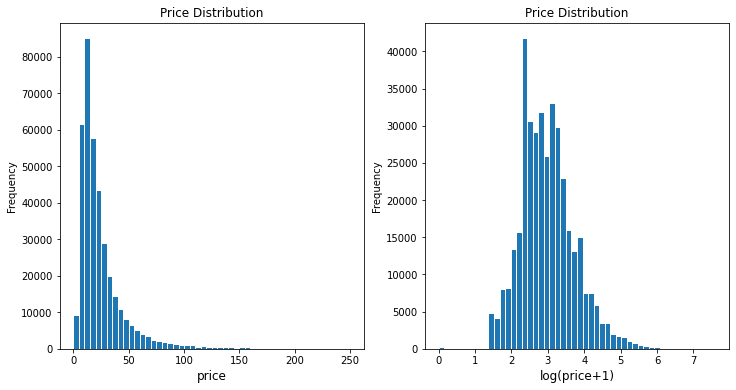

In [7]:
plt.subplot(1, 2, 1)
(train['price']).plot.hist(bins=50, figsize=(12, 6), edgecolor = 'white', range = [0, 250])
plt.xlabel('price', fontsize=12)
plt.title('Price Distribution', fontsize=12)
plt.subplot(1, 2, 2)
np.log(train['price']+1).plot.hist(bins=50, figsize=(12,6), edgecolor='white')
plt.xlabel('log(price+1)', fontsize=12)
plt.title('Price Distribution', fontsize=12)

# Shipping

Over 55% of items shipping fee were paid by the buyers.

In [8]:
train['shipping'].value_counts() / len(train)

0    0.553621
1    0.446379
Name: shipping, dtype: float64

How shipping related to the price?

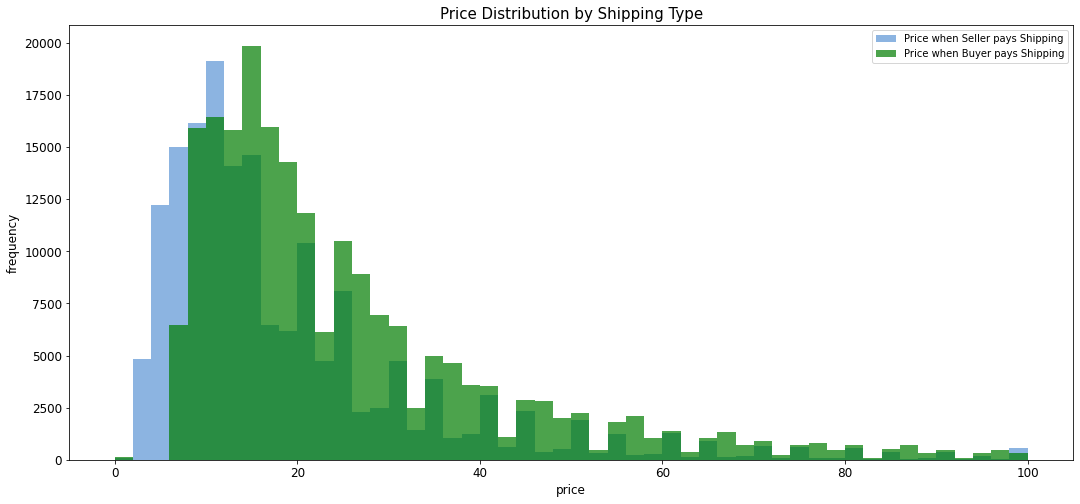

In [9]:
shipping_fee_by_buyer = train.loc[df['shipping'] == 0, 'price']
shipping_fee_by_seller = train.loc[df['shipping'] == 1, 'price']
fig, ax = plt.subplots(figsize=(18,8))
ax.hist(shipping_fee_by_seller, color='#8CB4E1', alpha=1.0, bins=50, range = [0, 100],
       label='Price when Seller pays Shipping')
ax.hist(shipping_fee_by_buyer, color='#007D00', alpha=0.7, bins=50, range = [0, 100],
       label='Price when Buyer pays Shipping')
plt.xlabel('price', fontsize=12)
plt.ylabel('frequency', fontsize=12)
plt.title('Price Distribution by Shipping Type', fontsize=15)
plt.tick_params(labelsize=12)
plt.legend()
plt.show()

*The average price is 22.58 if seller pays shipping*

*The average price is 30.11 if buyer pays shipping*

**We compare again after log-transformation on the price.**

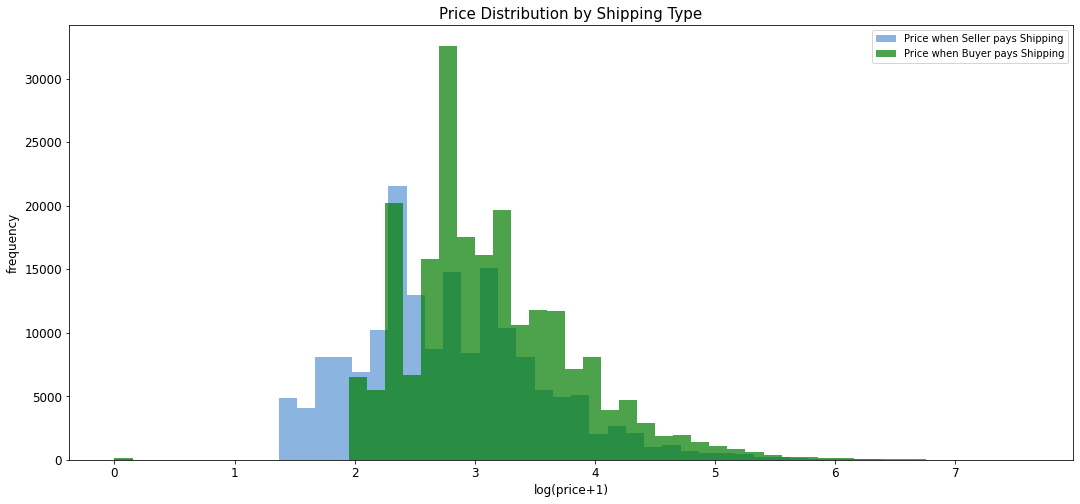

In [10]:
fig, ax = plt.subplots(figsize=(18,8))
ax.hist(np.log(shipping_fee_by_seller+1), color='#8CB4E1', alpha=1.0, bins=50,
       label='Price when Seller pays Shipping')
ax.hist(np.log(shipping_fee_by_buyer+1), color='#007D00', alpha=0.7, bins=50,
       label='Price when Buyer pays Shipping')
plt.xlabel('log(price+1)', fontsize=12)
plt.ylabel('frequency', fontsize=12)
plt.title('Price Distribution by Shipping Type', fontsize=15)
plt.tick_params(labelsize=12)
plt.legend()
plt.show()

It is obvious that the average price is higher when buyer pays shipping.

**Category** **Names**

In [11]:
print('There are', train['category_name'].nunique(), 'unique values in category name column')

There are 1148 unique values in category name column


Top 10 most common category names:

In [13]:
train['category_name'].value_counts()[:10]

Women/Athletic Apparel/Pants, Tights, Leggings                 15329
Women/Tops & Blouses/T-Shirts                                  11977
Beauty/Makeup/Face                                              8819
Beauty/Makeup/Lips                                              7616
Electronics/Video Games & Consoles/Games                        6835
Beauty/Makeup/Eyes                                              6525
Electronics/Cell Phones & Accessories/Cases, Covers & Skins     6445
Women/Underwear/Bras                                            5570
Women/Tops & Blouses/Tank, Cami                                 5233
Women/Tops & Blouses/Blouse                                     5198
Name: category_name, dtype: int64

Item condition vs. Price

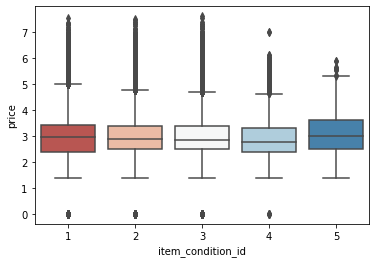

In [14]:
sns.boxplot(x = 'item_condition_id', y = np.log(train['price']+1), data = train, palette = sns.color_palette('RdBu',5))


In [15]:
NUM_BRANDS = 4000
NUM_CATEGORIES = 1000
NAME_MIN_DF = 10
MAX_FEATURES_ITEM_DESCRIPTION = 50000

There are missing values in the columns that we have to fix:

In [16]:
print('There are %d items that do not have a category name.' %train['category_name'].isnull().sum())

There are 1617 items that do not have a category name.


In [17]:
print('There are %d items that do not have a brand name.' %train['brand_name'].isnull().sum())

There are 162494 items that do not have a brand name.


In [18]:
print('There are %d items that do not have a description.' %train['item_description'].isnull().sum())

There are 0 items that do not have a description.


In [19]:
def handle_missing_inplace(dataset): 
    dataset['category_name'].fillna(value='missing', inplace=True) 
    dataset['brand_name'].fillna(value='missing', inplace=True) 
    dataset['item_description'].replace('No description yet,''missing', inplace=True) 
    dataset['item_description'].fillna(value='missing', inplace=True)
def cutting(dataset):
    pop_brand = dataset['brand_name'].value_counts().loc[lambda x: x.index != 'missing'].index[:NUM_BRANDS]
    dataset.loc[~dataset['brand_name'].isin(pop_brand), 'brand_name'] = 'missing'
    pop_category = dataset['category_name'].value_counts().loc[lambda x: x.index != 'missing'].index[:NUM_CATEGORIES]
def to_categorical(dataset):
    dataset['category_name'] = dataset['category_name'].astype('category')
    dataset['brand_name'] = dataset['brand_name'].astype('category')
    dataset['item_condition_id'] = dataset['item_condition_id'].astype('category')

In [20]:
df = pd.read_csv('train.tsv', sep = '\t')
msk = np.random.rand(len(df)) < 0.8
train = df[msk]
test = df[~msk]
test_new = test.drop('price', axis=1)
y_test = np.log1p(test["price"])
train = train[train.price != 0].reset_index(drop=True)

Merge train and new test data.

In [21]:
nrow_train = train.shape[0]
y = np.log1p(train["price"])
merge: pd.DataFrame = pd.concat([train, test_new])

*Training Preparation*

In [22]:
handle_missing_inplace(merge)
cutting(merge)
to_categorical(merge)

# Count vectorize name and category name columns.

In [23]:
cv = CountVectorizer(min_df=NAME_MIN_DF)
X_name = cv.fit_transform(merge['name'])
cv = CountVectorizer()
X_category = cv.fit_transform(merge['category_name'])

TF-IDF Vectorize item_description column.

In [24]:
tv = TfidfVectorizer(max_features=MAX_FEATURES_ITEM_DESCRIPTION, ngram_range=(1, 3), stop_words='english')
X_description = tv.fit_transform(merge['item_description'])


# Label binarize brand_name column.

In [25]:
lb = LabelBinarizer(sparse_output=True)
X_brand = lb.fit_transform(merge['brand_name'])

Create dummy variables for item_condition_id and shipping columns.

In [26]:
X_dummies = csr_matrix(pd.get_dummies(merge[['item_condition_id', 'shipping']], sparse=True).values)

Create sparse merge.

In [27]:
sparse_merge = hstack((X_dummies, X_description, X_brand, X_category, X_name)).tocsr()

Remove features with document frequency <=1.

In [28]:
mask = np.array(np.clip(sparse_merge.getnnz(axis=0) - 1, 0, 1), dtype=bool)
sparse_merge = sparse_merge[:, mask]

Separate train and test data from sparse merge.

In [29]:
X = sparse_merge[:nrow_train]
X_test = sparse_merge[nrow_train:]

Create dataset for lightgbm.

In [30]:
train_X = lgb.Dataset(X, label=y)

Specify our parameters as a dict.

In [31]:
params = {
        'learning_rate': 0.75,
        'application': 'regression',
        'max_depth': 3,
        'num_leaves': 100,
        'verbosity': -1,
        'metric': 'RMSE',
    }

1) Use ‘regression’ as application as we are dealing with a regression problem.

2) Use ‘RMSE’ as metric because this is a regression problem.

3) “num_leaves”=100 as
 our data is relative big.

4) Use “max_depth” to avoid overfitting.
Use “verbosity” to control the level of LightGBM’s verbosity (<0: Fatal).

5) “learning_rate” determines the impact of each tree on the final outcome.

# Training Start

Training a model requires a parameter list and data set. And training will take a while.

In [32]:
gbm = lgb.train(params, train_set=train_X, num_boost_round=3200, verbose_eval=100)

# Predict

In [33]:
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)

# Evaluation

In [34]:
from sklearn.metrics import mean_squared_error
print('The rmse of prediction is:', mean_squared_error(y_test, y_pred) ** 0.5)

The rmse of prediction is: 0.4792735155517121
